In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

### Curso-Taller 2019: Aprendizaje Automático e Imágenes en Python 
* Docentes:  Dra. Valeria S. Rulloni - Dra. Laura M. Vargas
* Ayudantes: Axel Aguerreberry - Sebastián Palacio
* Colaboradoras: Dra. Ana Carolina Maldonado - Dra. Claudia Egea

### Temario a desarrollar:
*	Uso y herramientas básicas de Python
*	Imágenes digitales: tipos (binarias, monocromáticas y a color)
*	Histograma. Mejora de la imagen: contraste, filtros: suavizado y detección de bordes.
*	Umbralado y Binarización. Operaciones Morfológicas: erosión, dilatación, cierre y apertura.
*	**Clasificación de imágenes.**
*	**Aprendizaje automático**
*	**Aprendizaje profundo: Redes neuronales**
*	Aplicaciones: Grafos para segmentación de imágenes, entre otras.



# Laboratorio Parte 3: Keras, MNIST data, aumentación de datos, redes neuronales convolucionales (CNN), drop-out

In [2]:
# importo librerias necesarias
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

Using TensorFlow backend.


In [3]:
sns.set_style("white")

In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [5]:
# importo y guardo MNIST data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Exploración del dataset

In [6]:
X_train = mnist.train.images
y_train = mnist.train.labels

X_val = mnist.validation.images
y_val = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

In [7]:
# Dimensiones de la data
print(f"Imagenes de Entrenamiento: {X_train.shape}")
print(f"Labels de Entrenamiento  : {y_val.shape}")
print()
print(f"Imagenes de Validacion   : {X_val.shape}")
print(f"Labels de Validacion     : {y_val.shape}")
print()
print(f"Imagenes de Testeo       : {X_test.shape}")
print(f"Labels de Testeo         : {y_test.shape}")

Imagenes de Entrenamiento: (55000, 784)
Labels de Entrenamiento  : (5000, 10)

Imagenes de Validacion   : (5000, 784)
Labels de Validacion     : (5000, 10)

Imagenes de Testeo       : (10000, 784)
Labels de Testeo         : (10000, 10)


In [8]:
##### Some Constants #####
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10

BATCH_SIZE = 32
NUM_EPOCHS = 10

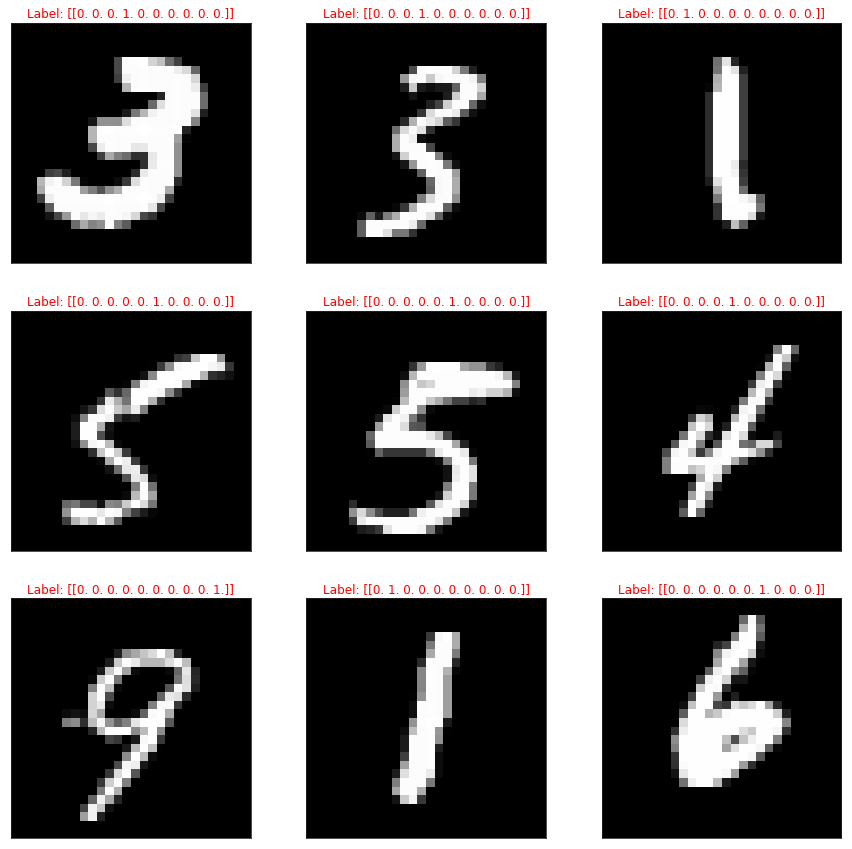

In [9]:
# Visualizamos algunas imagenes
fig, ax = plt.subplots(3, 3, figsize=[15, 15])

for j in range(3):
    for i in range(3):
        random_image = np.random.randint(low=0, high=55000, size=1)

        ax[i,j].imshow(X_train[random_image].reshape(28, 28), 'gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(f'Label: {y_train[random_image]}', color='r')

# fig.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

# Datos de entrenamiento para el Modelo

In [10]:
X_train = X_train.reshape(55000, 28, 28)
X_val = X_val.reshape(5000, 28, 28)
X_test = X_test.reshape(10000, 28, 28)

### Documentación de Keras: https://keras.io/

### Aumentación de datos por Rotación de Imágenes 

In [11]:
def rotacion(image, angle):
    height, width = image.shape[0], image.shape[1]
    medio = (width/2, height/2)

    M = cv2.getRotationMatrix2D(medio, angle, 1.0)
    imagen_rotada = cv2.warpAffine(image, M, (width, height))

    return imagen_rotada

In [12]:
def data_augmentation(images, labels):
    all_labels = []
    all_images = []

    for i in range(images.shape[0]):
        image, label = images[i], labels[i]

        all_images.append(image)
        all_labels.append(label)

        all_images.append(rotacion(image, 5))
        all_labels.append(label)    

        all_images.append(rotacion(image, -5))
        all_labels.append(label)

    return np.asarray(all_images), np.asarray(all_labels)

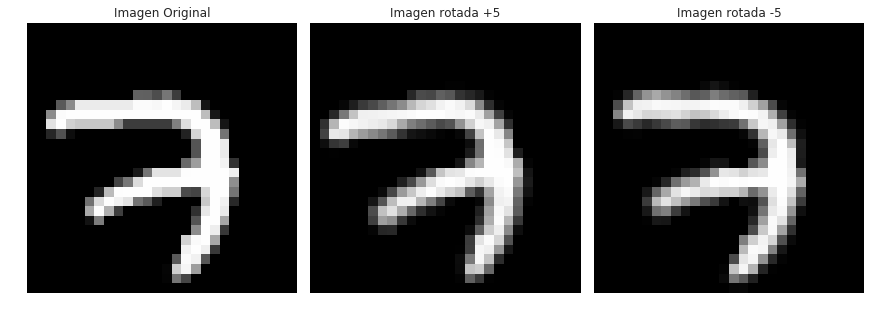

(28, 28)


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(X_train[0], 'gray', vmin=0, vmax=1);
ax[0].axis('off')
ax[0].set_title('Imagen Original')

ax[1].imshow(rotacion(X_train[0], 5), 'gray', vmin=0, vmax=1);
ax[1].axis('off')
ax[1].set_title('Imagen rotada +5')

ax[2].imshow(rotacion(X_train[0], -5), 'gray', vmin=0, vmax=1);
ax[2].axis('off')
ax[2].set_title('Imagen rotada -5')

fig.subplots_adjust(wspace=0.05, top=0.8)
plt.show()
print(rotacion(X_train[0], 5).shape)

In [14]:
X_train, y_train = data_augmentation(X_train, y_train)
print(X_train.shape, y_train.shape)

(165000, 28, 28) (165000, 10)


In [15]:
X_train = X_train.reshape(165000, 28, 28, 1)
X_val = X_val.reshape(5000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

### Uso de Drop out para evitar sobre-ajuste (overfitting) del modelo

In [16]:
### A completar: definir capa de entrada, capas ocultas, y capa de salida

inputs = Input(shape=(IMG_ROWS, IMG_COLS, 1))

conv1 = Conv2D(64, 5, activation=None)(inputs)
bn1 = BatchNormalization()(conv1)
activation1 = Activation("relu")(bn1)
maxPool1 = MaxPooling2D(pool_size=(2, 2))(activation1)

conv2 = Conv2D(128, 5, activation=None)(maxPool1)
bn2 = BatchNormalization()(conv2)
activation2 = Activation("relu")(bn2)
maxPool2 = MaxPooling2D(pool_size=(2, 2))(activation2)

flatten = Flatten()(maxPool2)

dense1 = Dense(256, activation="sigmoid")(flatten)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation="sigmoid")(dense1)
dense2 = Dropout(0.5)(dense2)

outputs = Dense(NUM_CLASSES, activation="softmax")(dense2)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
### A completar: definir entrada y salida del modelo
model = Model(
    inputs=inputs,
    outputs=outputs
)

In [18]:
### A completar: definir optimizador y funcion de costo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512 

In [20]:
## para guardar el modelo
filepath = "prueba3.h5"
model_checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True
)

In [21]:
%%time
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 165000 samples, validate on 5000 samples
Epoch 1/10
165000/165000 [==============================] - 380s 2ms/step - loss: 0.1634 - acc: 0.9609 - val_loss: 0.0438 - val_acc: 0.9880

Epoch 00001: loss improved from inf to 0.16341, saving model to prueba3.h5
Epoch 2/10
165000/165000 [==============================] - 379s 2ms/step - loss: 0.0571 - acc: 0.9857 - val_loss: 0.0341 - val_acc: 0.9900

Epoch 00002: loss improved from 0.16341 to 0.05710, saving model to prueba3.h5
Epoch 3/10
165000/165000 [==============================] - 380s 2ms/step - loss: 0.0397 - acc: 0.9902 - val_loss: 0.0251 - val_acc: 0.9932

Epoch 00003: loss improved from 0.05710 to 0.03973, saving model to prueba3.h5
Epoch 4/10
165000/165000 [==============================] - 380s 2ms/step - loss: 0.0298 - acc: 0.9924 - val_loss: 0.0354 - val_acc: 0.9918

Epoch 00004: loss improved from 0.03973 to 0.02976, savin

In [22]:
print("Accuracy:")
print(f"\t* Train = {model.evaluate(X_train, y_train)}")
print(f"\t* Val   = {model.evaluate(X_val, y_val)}")
print(f"\t* Test  = {model.evaluate(X_test, y_test)}")

Accuracy:
165000/165000 [==============================] - 97s 588us/step
	* Train = [0.00419220606380967, 0.9988303030303031]
5000/5000 [==============================] - 3s 586us/step
	* Val   = [0.03551698296451859, 0.9944]
10000/10000 [==============================] - 6s 591us/step
	* Test  = [0.02975730240074922, 0.9941]


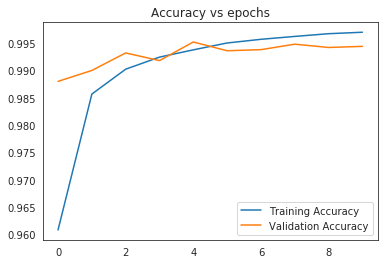

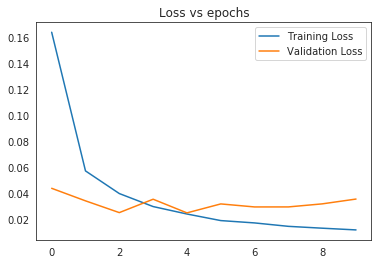

In [23]:
## Visualizamos curvas de entrenamiento

plt.figure()
plt.title("Accuracy vs epochs")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])


plt.figure()
plt.title("Loss vs epochs")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

## Usemos este modelo para hacer predicciones

In [24]:
## A completar: utilizar imagenes de testeo

predictions = model.predict(X_test)

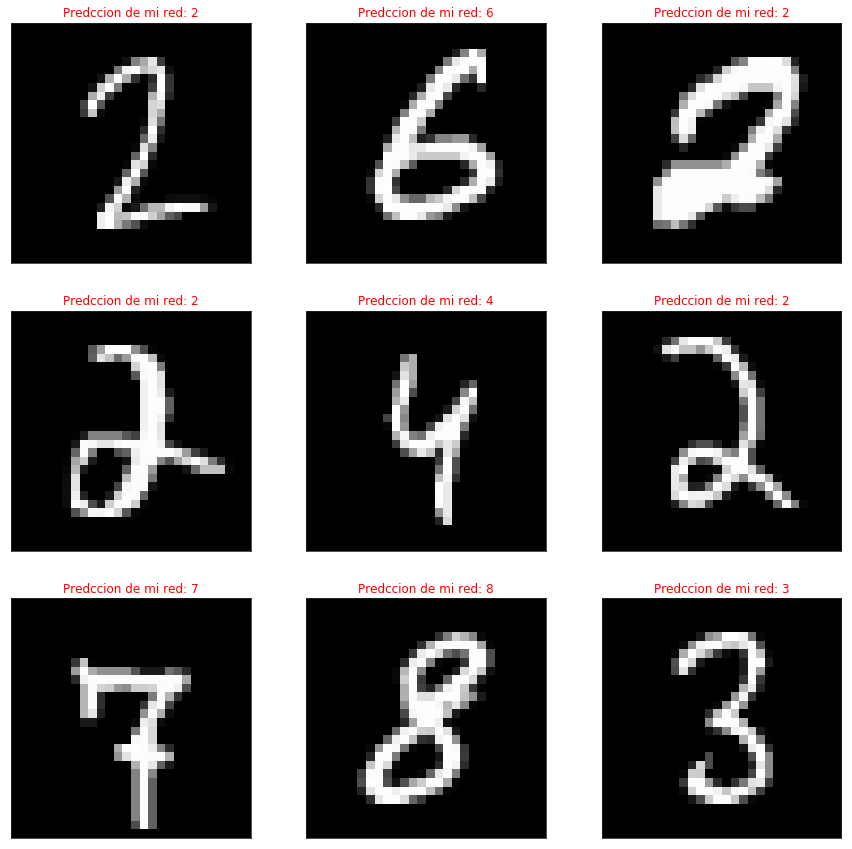

In [25]:
fig, ax = plt.subplots(3, 3, figsize=[15, 15])

for j in range(3):
    for i in range(3):
        random_image = np.random.randint(low=0, high=1000, size=1)

        ax[i,j].imshow(X_test[random_image].reshape(28,28), 'gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(f'Predccion de mi red: {np.argmax(predictions[random_image])}', color='r')

plt.show()